In [1]:
# General imports
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [2]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=True) # switched simulator to True
backend.name

'simulator_statevector'

In [3]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

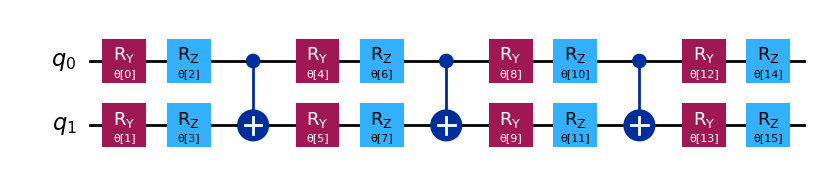

In [4]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

In [5]:
num_params = ansatz.num_parameters
num_params

16

In [6]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

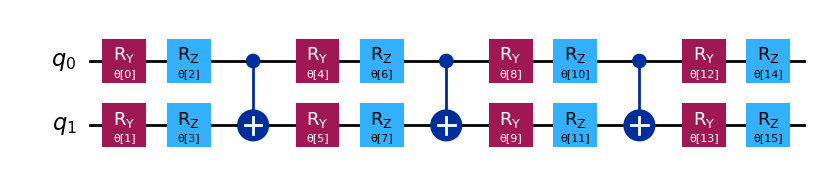

In [7]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [8]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [9]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    return energy

In [10]:
def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        """Callback function storing previous solution vector,
        computing the intermediate cost value, and displaying number
        of completed iterations and average time per iteration.

        Values are stored in pre-defined 'callback_dict' dictionary.

        Parameters:
            current_vector (ndarray): Current vector of parameters
                                      returned by optimizer
        """
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        pub = (ansatz, [hamiltonian], [current_vector])
        result = estimator.run(pubs=[pub]).result()
        current_cost = result[0].data.evs[0]
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback

In [11]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [12]:
x0 = 2 * np.pi * np.random.random(num_params)

In [13]:
x0

array([2.96062254, 0.61520671, 3.2159319 , 2.96519876, 2.29970822,
       4.47083464, 5.07324892, 2.26378969, 3.42482332, 5.23752945,
       5.66730288, 1.05237793, 1.0847757 , 0.96872688, 1.68014834,
       5.42046009])

In [14]:
# To run on local simulator:
#   1. Use the Estimator from qiskit.primitives instead.
#   2. Remove the Session context manager below.
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 10_000

    callback = build_callback(ansatz_isa, hamiltonian_isa, estimator, callback_dict)

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
        callback=callback,
    )

In [15]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.6738100838658148
       x: [ 3.795e+00  1.418e+00 ...  1.147e+00  4.752e+00]
    nfev: 183
   maxcv: 0.0

In [16]:
all(callback_dict["prev_vector"] == res.x)

True

In [17]:
callback_dict["iters"] == res.nfev

True

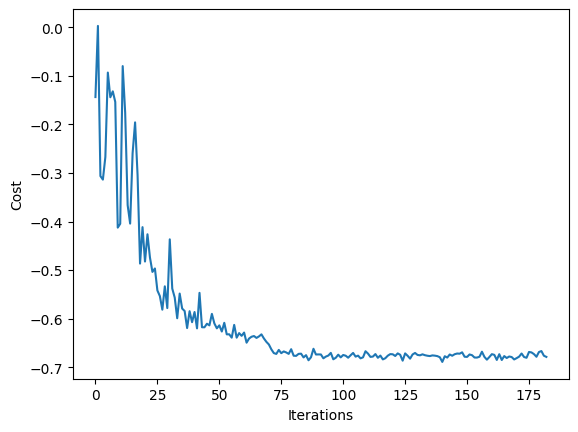

In [18]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()